In [109]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns


reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [110]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme
)

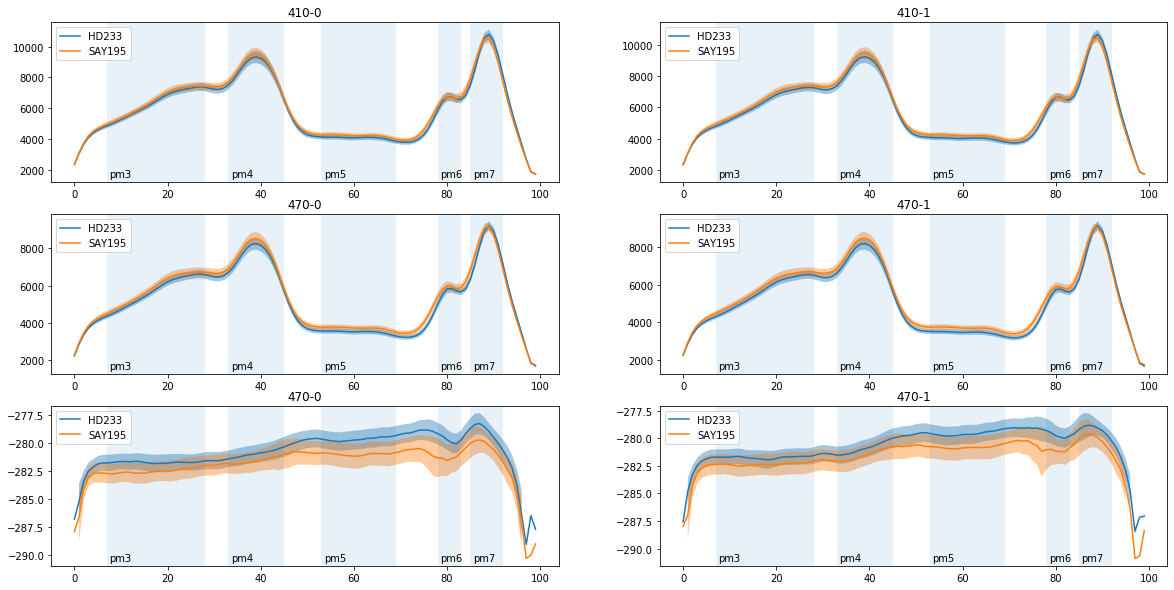

In [112]:
reload(plots)
plots.plot_paired_experiment_summary(ex);

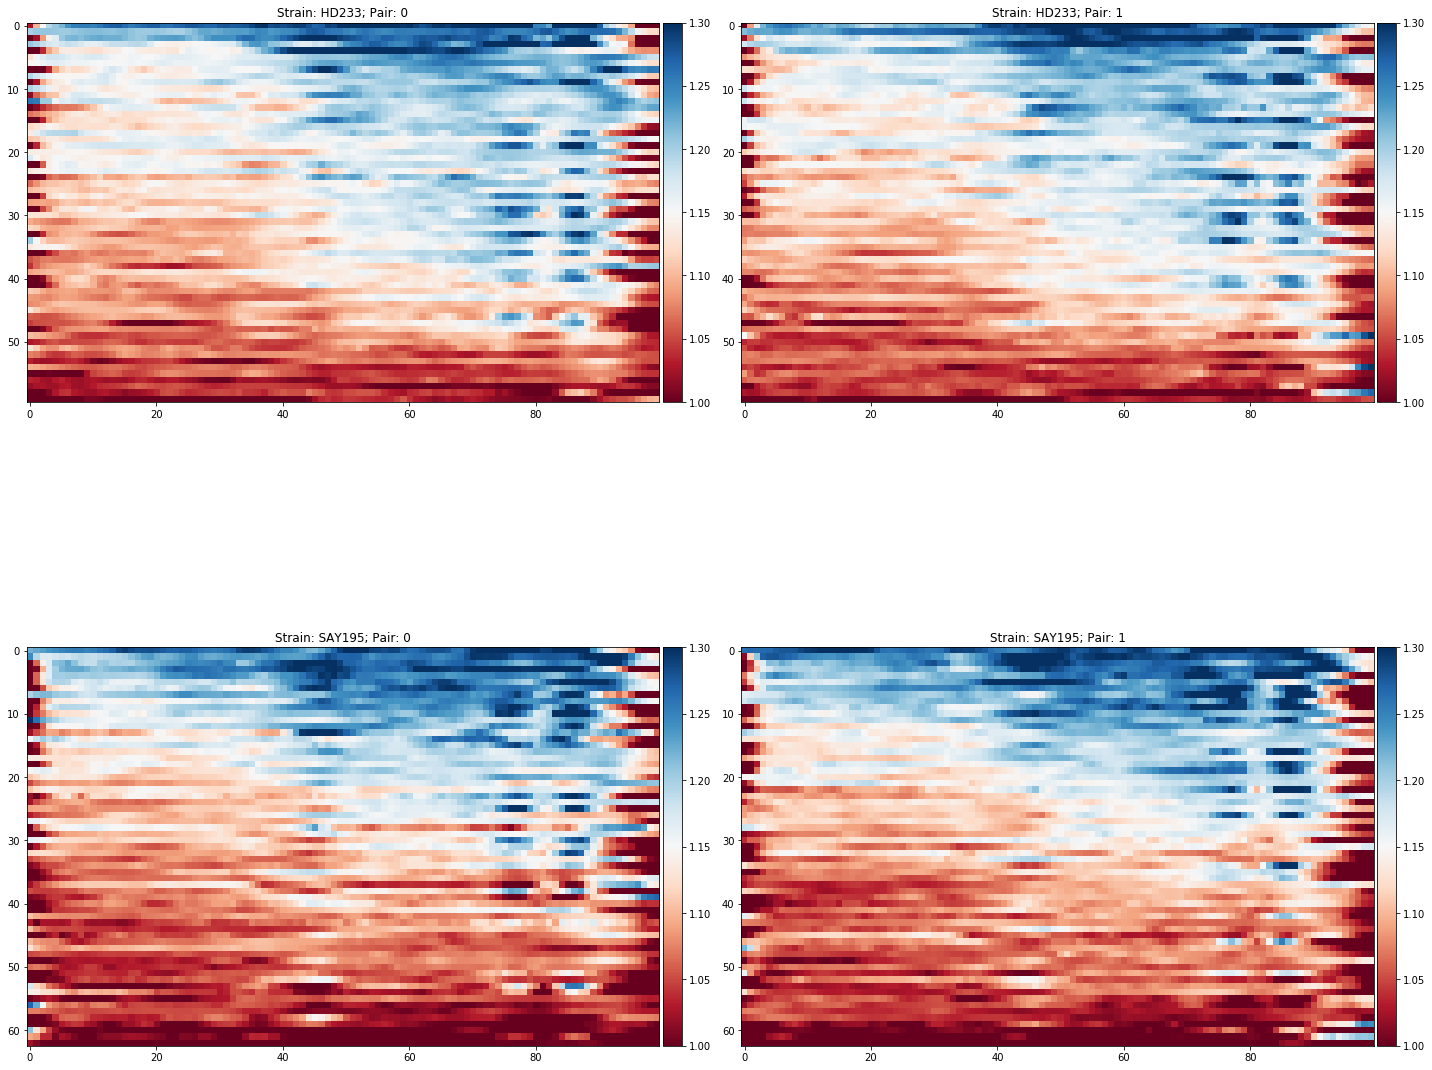

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = ex.trimmed_intensity_data.sel(wavelength='r')

strains = np.unique(data.strain.data)
n_strains = len(strains)
n_pairs = len(data.pair)
fig, axes = plt.subplots(n_strains, n_pairs, figsize=(20,20))
for strain, ax in zip(strains, axes):
    for i in range(n_pairs):
        subset = data.sel(strain=strain).isel(pair=i)
        sorted_idx = np.flip(np.argsort(subset.mean(dim='position'))).data
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='3%', pad=0.05)

        ax[i].set_title(f'Strain: {strain}; Pair: {i}')
        im = ax[i].imshow(subset[sorted_idx], cmap='RdBu')
        im.set_clim([1, 1.3])
        fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

In [14]:
dp = pd.read_csv('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv')
dp = dp[dp.experiment == '2017_02_22-HD233_SAY47']
dp = dp.pivot_table(index='animal', columns=['region', 'pair'], values='movement')
dp = dp.stack('pair')
dp.head()

region       anterior_bulb  posterior_bulb  sides_of_tip  tip
animal pair                                                  
0      0                 0               0             0    1
       1                 0               0             0    0
1      0                 0               0             1    0
       1                 1               1             1    1
2      0                 0               0             0    0

In [16]:
data = ex.trimmed_intensity_data
dfs = []
for region, bounds in ex.scaled_regions.items():
    region_dfs = []
    for wvl in data.wavelength.data:
        sub_df = ex.trimmed_intensity_data[dict(position=range(bounds[0],bounds[1]))].mean(dim='position').sel(wavelength=wvl).to_pandas()
        sub_df = sub_df.reset_index()
        sub_df['animal'] = range(len(sub_df))
        sub_df['region'] = region
        sub_df['experiment'] = ex.experiment_id
        sub_df = sub_df.melt(value_vars=[0, 1], var_name='pair', id_vars=['animal', 'strain', 'region', 'experiment'], value_name=wvl)
        region_dfs.append(sub_df)
    df_tmp = pd.concat(region_dfs, axis=1)
    df_tmp = df_tmp.loc[:,~df_tmp.columns.duplicated()]
    dfs.append(df_tmp)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df = df.join(dp, on=['animal', 'pair'])
df.to_csv('/Users/sean/Desktop/regions.csv', index=False)
df.head()

,animal,strain,region,experiment,pair,470,410,r,oxd,e,anterior_bulb,posterior_bulb,sides_of_tip,tip
0,0,HD233,pm3,2017_02_22-HD233_SAY47,0,5883.051002,7865.030482,1.335960,0.347184,-273.040821,0,0,0,1
1,1,HD233,pm3,2017_02_22-HD233_SAY47,0,5442.450628,7864.150272,1.442183,0.398368,-270.246822,0,0,1,0
2,2,HD233,pm3,2017_02_22-HD233_SAY47,0,6947.042132,9315.402888,1.340667,0.349889,-272.879145,0,0,0,0
3,3,HD233,pm3,2017_02_22-HD233_SAY47,0,6205.373554,8620.839072,1.388857,0.373659,-271.570599,0,0,0,0
4,4,HD233,pm3,2017_02_22-HD233_SAY47,0,6733.995508,9508.305852,1.410939,0.384156,-271.002636,0,0,0,0


NameError: name 'hide_current_axis' is not defined

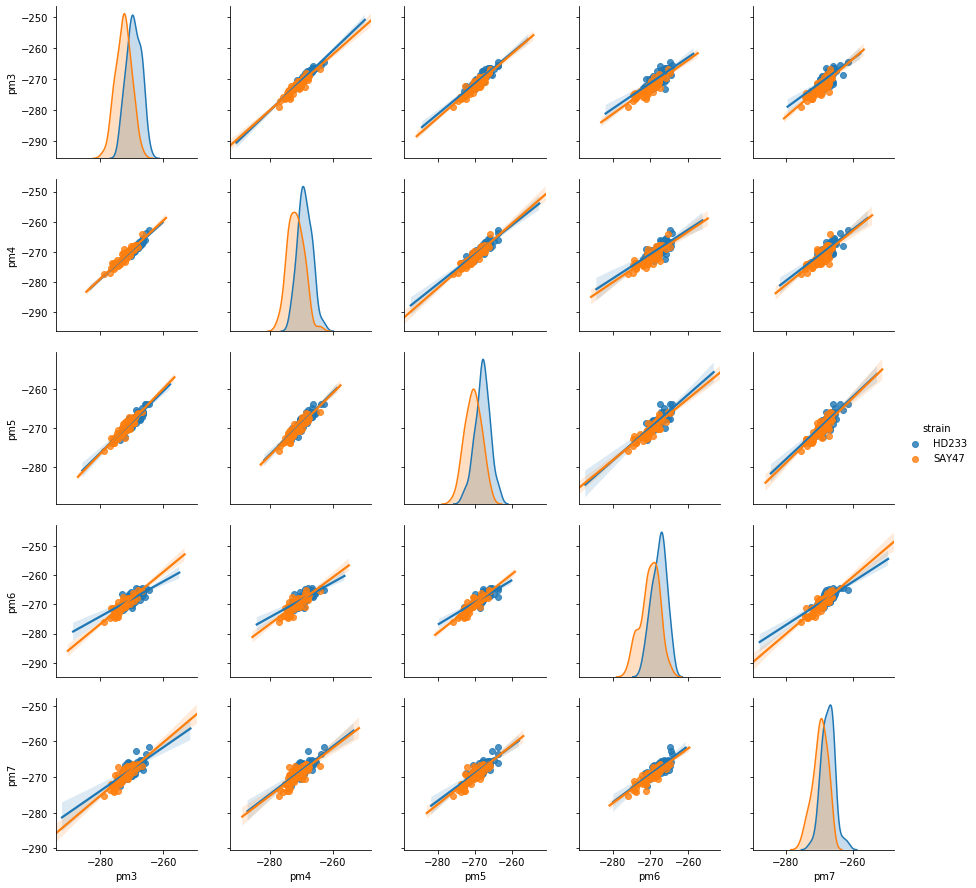

In [819]:
g = sns.pairplot(reshaped, kind='reg', diag_kind='kde', hue='strain', )
g.map_upper(hide_current_axis)

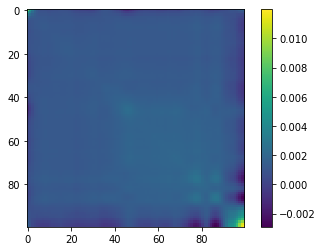

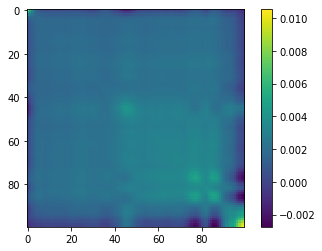

In [37]:
hd233 = ex.trimmed_intensity_data.sel(wavelength='oxd', pair=0, strain='HD233')
say47 = ex.trimmed_intensity_data.sel(wavelength='oxd', pair=0, strain='SAY195')

plt.imshow(np.cov(hd233.T))
# plt.clim([0, 20])
plt.colorbar()
plt.figure()
plt.imshow(np.cov(say47.T))
# plt.clim([0, 20])
plt.colorbar()
